# Regression

Para el caso de regresión, a partir de las columnas de `CLASE` y `MPIO_ID`, `HORA` y `DIASEMANA` se crea una variable continua la cual será la variable dependiente a predecir, que es la severidad de un accidente de acuerdo a estas variables y la cual se calcula de la siguiente forma:

$$
\text{Probabilidad de Severidad} = \frac{\text{Accidentes fatales} + \text{Accidentes no fatales}}{\text{Total de accidentes en el grupo}}
$$

La forma para la elección del modelo será con el mejor resultado dado por **Cross Validation** con diferentes hiperparámetros aplicados a cada modelo, tomando los modelos de regresión como **Decision Tree, Random Forest y LightGBM**.

Debido a que las claves de los municipios podrían repetirse ya que dependen de su estado, se hizo una unión para identificarlos de otra manera con estado y municipio.

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv('../data/processed/processed_nacional.csv')

In [3]:
df['MPIO_ID'] = (df['EDO'].astype(str).str.zfill(2) + df['MPIO'].astype(str).str.zfill(3)).astype(int)

In [4]:
# Calcular la probabilidad de severidad a partir del municipio, hora y día de la semana
df_grouped = df.groupby(['MPIO_ID', 'HORA', 'DIASEMANA']).agg(
    TOTACCID=('CLASE', 'count'),
    # Fatales + no fatales
    ACCIDSEVEROS=('CLASE', lambda x: ((x == 1) | (x == 2)).sum())  
).reset_index()

# Calcular la probabilidad de que un accidente sea severo
df_grouped['PROBSEVERIDAD'] = df_grouped['ACCIDSEVEROS'] / df_grouped['TOTACCID']

X = df_grouped[['MPIO_ID', 'HORA', 'DIASEMANA', 'TOTACCID', 'ACCIDSEVEROS']]
y = df_grouped['PROBSEVERIDAD']

print(df_grouped.info())

df_grouped.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13377 entries, 0 to 13376
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MPIO_ID        13377 non-null  int32  
 1   HORA           13377 non-null  int64  
 2   DIASEMANA      13377 non-null  int64  
 3   TOTACCID       13377 non-null  int64  
 4   ACCIDSEVEROS   13377 non-null  int64  
 5   PROBSEVERIDAD  13377 non-null  float64
dtypes: float64(1), int32(1), int64(4)
memory usage: 574.9 KB
None


,MPIO_ID,HORA,DIASEMANA,TOTACCID,ACCIDSEVEROS,PROBSEVERIDAD
0,1001,0,1,21,7,0.333333
1,1001,0,2,6,2,0.333333
2,1001,0,3,3,0,0.000000
3,1001,0,4,14,5,0.357143
4,1001,0,5,15,3,0.200000


In [5]:
df_grouped.describe()

,MPIO_ID,HORA,DIASEMANA,TOTACCID,ACCIDSEVEROS,PROBSEVERIDAD
count,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000,13377.000000
mean,15906.451147,11.819541,4.037004,13.472303,1.926441,0.180631
std,8139.685610,6.786244,2.010378,27.290138,2.823713,0.228961
min,1001.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,9010.000000,6.000000,2.000000,3.000000,0.000000,0.000000
50%,16053.000000,12.000000,4.000000,7.000000,1.000000,0.111111
75%,23001.000000,18.000000,6.000000,15.000000,3.000000,0.285714
max,32056.000000,23.000000,7.000000,443.000000,26.000000,1.000000


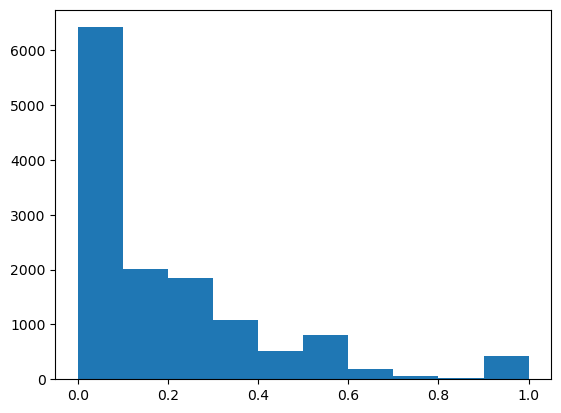

In [6]:
plt.hist(df_grouped['PROBSEVERIDAD'])
plt.show()

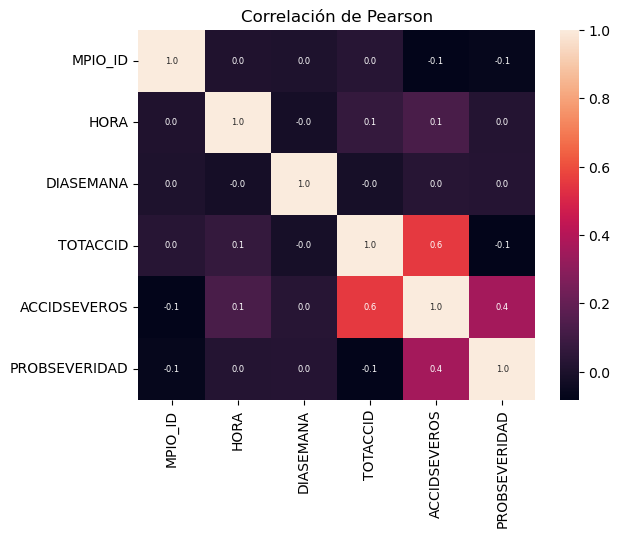

In [7]:
corr = df_grouped.corr(method='pearson')

sns.heatmap(corr, annot=True, fmt=".1f", annot_kws={"size": 6})
plt.title("Correlación de Pearson")

plt.show()

In [8]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X_train)

In [10]:
tree = DecisionTreeRegressor()
r_forest = RandomForestRegressor()
lgbm = LGBMRegressor()

In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

### Decision Tree Regressor

In [12]:
tree_params = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [3, 7, 9, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 5],
    'splitter': ['best', 'random'],
    'max_features': ['sqrt', 'log2', None],
    'min_impurity_decrease': [0.0, 0.05, 0.1],
    'random_state': [42]
}

In [13]:
tree_cv = RandomizedSearchCV(
    estimator=tree,
    param_distributions=tree_params,
    cv=cv,
    scoring='neg_mean_absolute_error',
    verbose=1
)

In [14]:
tree_cv.fit(X_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=DecisionTreeRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [3, 7, 9, 10, 12, 15],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_impurity_decrease': [0.0, 0.05,
                                                                  0.1],
                                        'min_samples_leaf': [1, 2, 3, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'random_state': [42],
                                        'splitter': ['best', 'random']},
                   scoring='neg_mean_absolute_error', verbose=1)

In [15]:
tree_cv.best_params_

{'splitter': 'best',
 'random_state': 42,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0.0,
 'max_features': None,
 'max_depth': 7,
 'criterion': 'squared_error'}

In [16]:
tree_cv.best_score_

-0.01851083221692634

### Random Forest Regressor

In [17]:
r_forest_params = {
    'n_estimators': [50, 100, 200, 300],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': [3, 7, 9, 10, 11, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 7, 9],
    'max_features': ['sqrt', 'log2', None],
    'random_state': [42]
}

In [18]:
r_forest_cv = RandomizedSearchCV(
    estimator=r_forest,
    param_distributions=r_forest_params,
    cv=cv,
    scoring='neg_mean_absolute_error',
    verbose=1
)

In [19]:
r_forest_cv.fit(X_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(),
                   param_distributions={'criterion': ['squared_error',
                                                      'friedman_mse',
                                                      'absolute_error',
                                                      'poisson'],
                                        'max_depth': [3, 7, 9, 10, 11, 12, 15],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [2, 5, 7, 9],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'random_state': [42]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [20]:
r_forest_cv.best_params_

{'random_state': 42,
 'n_estimators': 50,
 'min_samples_split': 2,
 'min_samples_leaf': 9,
 'max_features': None,
 'max_depth': 9,
 'criterion': 'friedman_mse'}

In [21]:
r_forest_cv.best_score_

-0.004423715774556277

### Light GBM Regressor

In [22]:
lgbm_params = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 64]
}

In [23]:
lgbm_cv = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_params,
    cv=cv,
    scoring='neg_mean_absolute_error',
    verbose=1
)

In [24]:
lgbm_cv.fit(X_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 5
[LightGBM] [Info] Start training from score 0.177547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 5
[LightGBM] [Info] Start training from score 0.180901
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you ca

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 7491, number of used features: 5
[LightGBM] [Info] Start training from score 0.181139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 257
[LightGBM] [Info] Number of data points in the train set: 7491, number of used features: 5
[LightGBM] [Info] Start training from score 0.180320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 5
[LightGBM] [Info] Start training from score 0.177547
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 5
[LightGBM] [Info] Start training from score 0.180901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 7490, number of used features: 5
[LightGBM] [Info] Start training fro

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LGBMRegressor(),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'n_estimators': [50, 100, 200, 300],
                                        'num_leaves': [31, 50, 64]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [25]:
lgbm_cv.best_params_

{'num_leaves': 50, 'n_estimators': 300, 'learning_rate': 0.1}

In [26]:
lgbm_cv.best_score_

-0.0013966842315583934

---
# Prueba Test con LightGBM

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [28]:
X_test_scaled = scaler.transform(X_test)

In [29]:
best_model = LGBMRegressor(**lgbm_cv.best_params_, random_forest=42)

In [31]:
best_model.fit(X_scaled, y_train)

[LightGBM] [Warning] Unknown parameter: random_forest
[LightGBM] [Warning] Unknown parameter: random_forest
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 267
[LightGBM] [Info] Number of data points in the train set: 9363, number of used features: 5
[LightGBM] [Info] Start training from score 0.180378


LGBMRegressor(n_estimators=300, num_leaves=50, random_forest=42)

In [32]:
y_pred = best_model.predict(X_test_scaled)

[LightGBM] [Warning] Unknown parameter: random_forest


In [33]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 0.0011735200886366292
Mean Squared Error (MSE): 2.9202691640406235e-05
R² Score: 0.9994373006586694


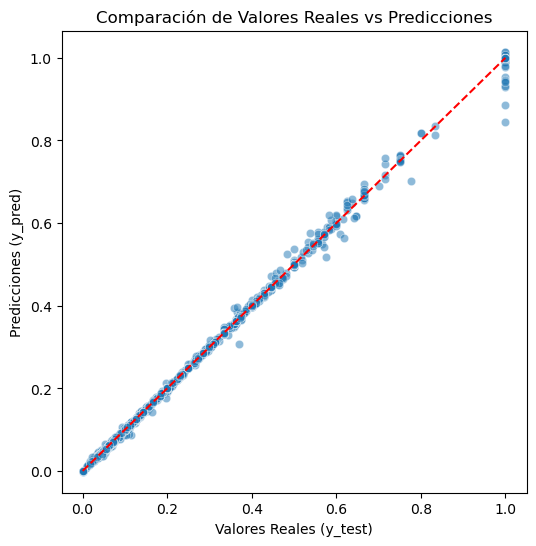

In [35]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.xlabel("Valores Reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Comparación de Valores Reales vs Predicciones")

plt.show()